In [24]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import numpy as np

import warnings
warnings.filterwarnings(action='once')

sns.set_style("darkgrid")
sns.set(font_scale=1.5)
%matplotlib inline

In [25]:
def query_data(query, parms=None):
    """Shared query wrapper"""
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    with engine.connect() as conn:
        data = pd.read_sql(sql=query, con=conn, params=parms)
    return data

In [26]:
def get_departure_status():
    """Get all distinct values for departure status"""
    query_string = """
    SELECT
        DISTINCT f.departure_status as status
    FROM
        flights as f
    """
    return query_data(query_string)

In [33]:
def get_features_by_status(status='On-Time', limit=10):
    """Query departure data from flights for selected origin airport and year"""
    
    query_string = """
    SELECT
        f.departure_status               AS status,
        f.origin_airport_id              AS origin_airport_id,
        f.dest_airport_id                AS destintion_airport_id,
        f.month                          AS month,
        f.day_of_week                    AS day_of_week,
        f.departure_time_scheduled       AS departure_time_scheduled,
        f.distance                       AS distance,
        f.elapsed_time_scheduled         AS scheduled_travel_time,
        d1.scheduled_departures          AS scheduled_departures_hour_back,
        d1.fraction_cancelled_departures AS fraction_cancelled_hour_back,
        d1.fraction_departures_delayed   AS fraction_delayed_hour_back,
        d1.average_delay_departures      AS average_delay_hour_back,
        d2.scheduled_departures          AS scheduled_departures_two_hours_back,
        d2.fraction_cancelled_departures AS fraction_cancelled_two_hours_back,
        d2.fraction_departures_delayed   AS fraction_delayed_two_hours_back,
        d2.average_delay_departures      AS average_delay_two_hours_back,
        d3.scheduled_departures          AS scheduled_departures_three_hours_back,
        d3.fraction_cancelled_departures AS fraction_cancelled_three_hours_back,
        d3.fraction_departures_delayed   AS fraction_delayed_three_hours_back,
        d3.average_delay_departures      AS average_delay_three_hours_back
    FROM
        flights AS f
    JOIN departure_features as d1
      ON f.origin_airport_id = d1.departure_airport_id
     AND f.departure_hour_scheduled_minus_one_hours = d1.scheduled_departure_hour
    JOIN departure_features as d2
      ON f.origin_airport_id = d2.departure_airport_id
     AND f.departure_hour_scheduled_minus_two_hours = d2.scheduled_departure_hour
    JOIN departure_features as d3
      ON f.origin_airport_id = d3.departure_airport_id
     AND f.departure_hour_scheduled_minus_three_hours = d3.scheduled_departure_hour
    WHERE 
        f.departure_status = :status
    LIMIT :limit
    """
    return query_data(query_string, parms={'status':status, 'limit':limit})

In [90]:
def get_observations_in_equal_numbers_per_status(limit_per_status=10000):
    target_status = get_departure_status()
    out_data = {}
    for status in target_status.status.values:
        print(f"Query {limit_per_status} observations for {status}")
        data = get_features_by_status(status=status, limit=limit_per_status)
        out_data[status] = data
        
    return out_data
        
data = get_observations_in_equal_numbers_per_status()

Query 10000 observations for ON_TIME
Query 10000 observations for DELAYED_15_TO_30
Query 10000 observations for CANCELLED
Query 10000 observations for DELAYED_31_TO_60
Query 10000 observations for DELAYED_61_TO_120
Query 10000 observations for DELAYED_120_PLUS
Query 10000 observations for EARLY


In [102]:
def get_target_and_features(data):
    target = data.status
    features = data.drop(['status', 'departure_time_scheduled'], axis=1)
    return target, features

def combine_dataframes(data):
    dataframes = []
    for key, value in data.items():
        dataframes.append(value)

    data = pd.concat(dataframes, ignore_index=True)
    return get_target_and_features(data)

target, features = combine_dataframes(data)

# To what extent are there correlations in the existing features?

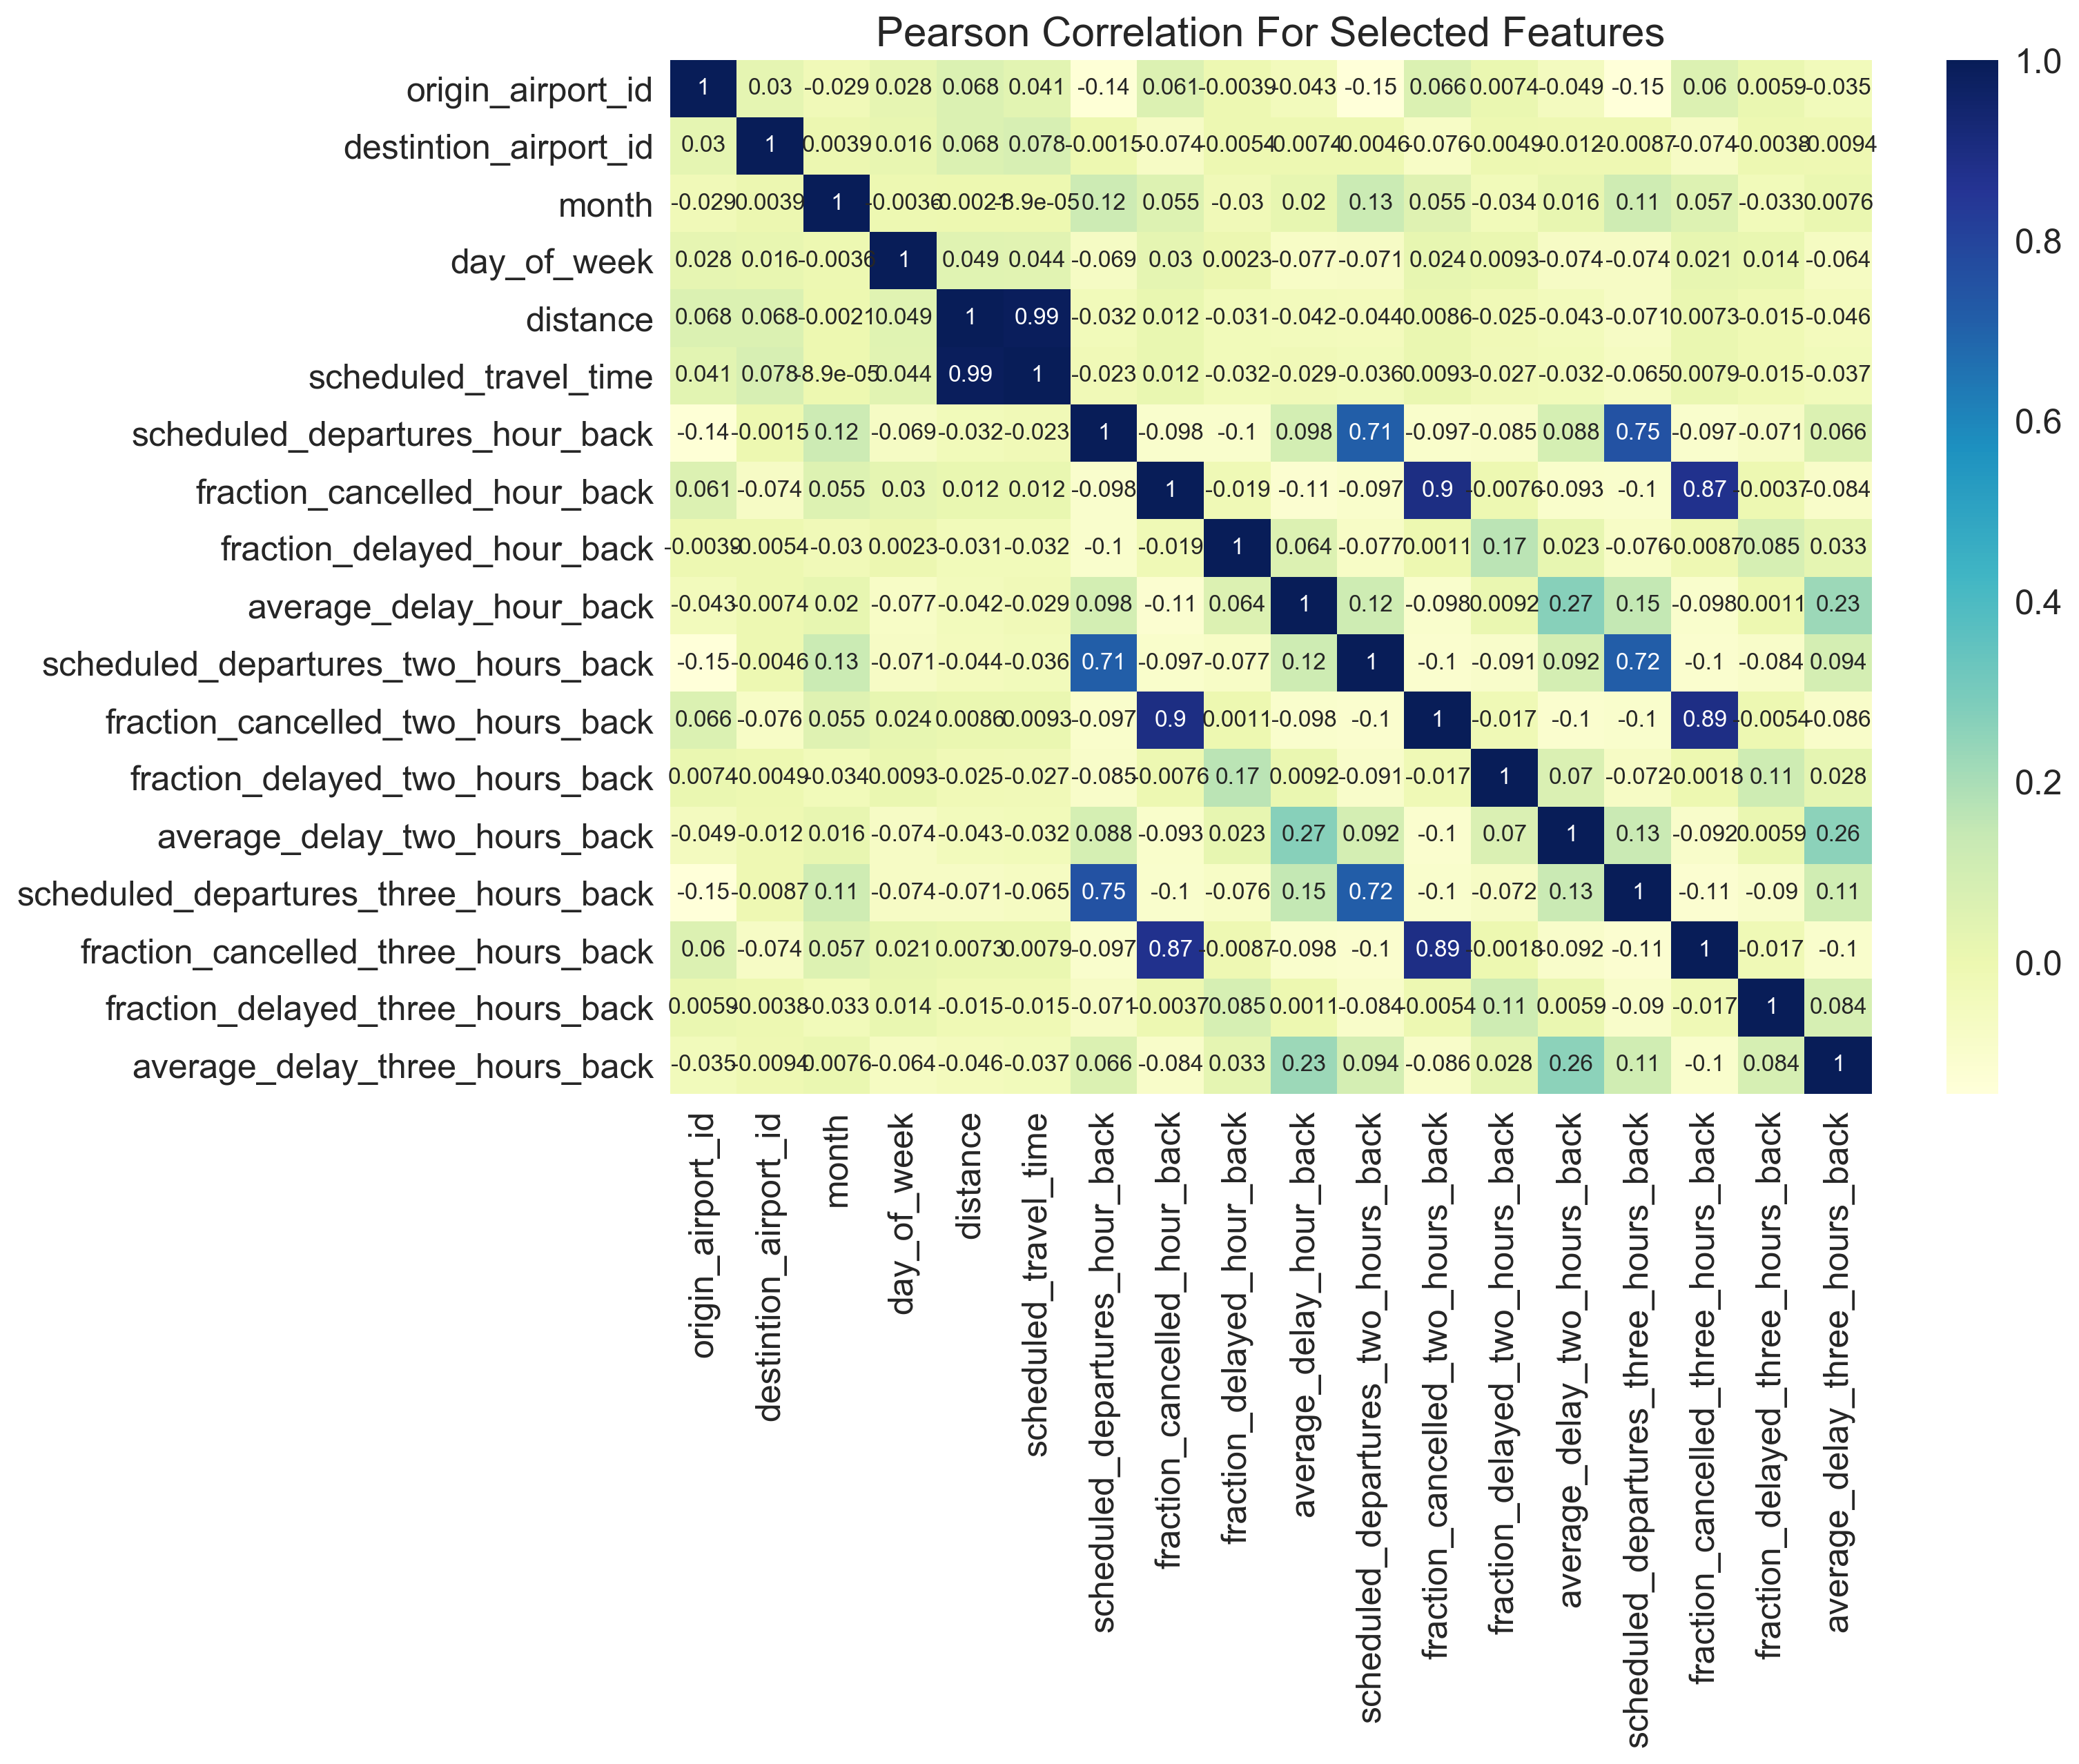

In [104]:
def plot_correlation_heatmap(correlation_matrix, save_image=False):
    fig, ax = plt.subplots(figsize=(11.7, 8.27), dpi=240)

    plt.title("Pearson Correlation For Selected Features")
    sns.heatmap(correlation_matrix, ax=ax, annot=True,  cmap="YlGnBu")
    plt.show()
    
plot_correlation_heatmap(features.corr(), save_image=True)

There High levels of correlation between elapsed time and flight distance (i.e. a flight that travels further will be in the air longer.)  Also, for this iteration, year is constant and should be dropped from feature space.

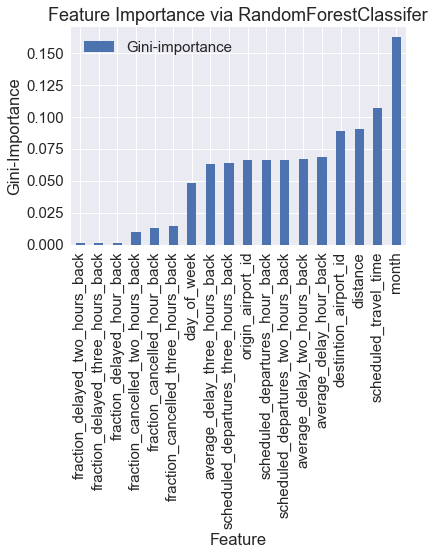

In [105]:
## generate a plot of gini importances with and without balance classes, showing that even that one small change can have an impact on what is important

from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd

def estimate_feature_importances(X, y, feature_names, class_weight=None):
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0, class_weight=class_weight)
    forest.fit(X, y)
    
    features = {}
    for feature, importance in zip(feature_names, forest.feature_importances_):
        features[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(features, orient='index').rename(columns={0: 'Gini-importance'})
    
    importances.sort_values(by='Gini-importance').plot(kind='bar')
    plt.xlabel('Feature')
    plt.ylabel('Gini-Importance')
    plt.title('Feature Importance via RandomForestClassifer')
    plt.show()
    return importances

importances = estimate_feature_importances(X=features, y=target, feature_names=features.columns)

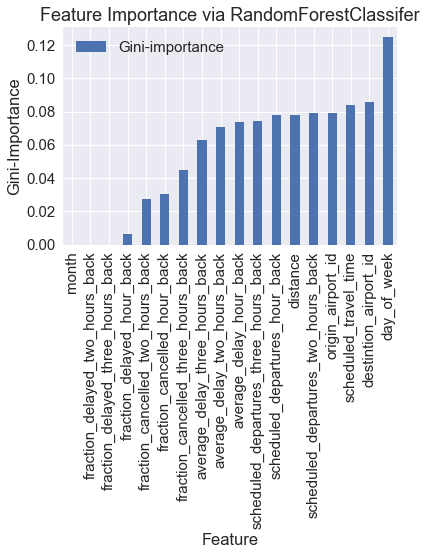

In [61]:
importances = estimate_feature_importances(X=features, y=target, feature_names=features.columns, class_weight='balanced')

In [121]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline

def evaluate_pipeline(X, y, param_grid, pipeline, scoring='accuracy', random_state=12):
    """ Conduct a GridSearchCV with supplied pipeline and parameters, use reserved data for output metrics"""
    
    # Reserve a portion of the data, to reduce overfitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    
    # Initiate GridSearchCV, with 5-fold cross validtation schema, using selected scoring method
    grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring=scoring)
   
    # Fit the Grid to the training data
    grid.fit(X=X_train, y=y_train)
    
    # Inspect the output of the gridsearch
    print("   Scoring Methodology:", scoring)
    print("            Best Score:", grid.best_score_)
    print("        Best Estimator:")
    print(grid.best_estimator_)
    
    
    
    # Use the fitted grid to predict on the test data
    y_pred = grid.predict(X_test)
    print("----------------- Test Set Results -----------------")
    print("              Accuracy:", accuracy_score(y_pred=y_pred, y_true=y_test))
    print(" Classification Report:\n", classification_report(y_pred=y_pred, y_true=y_test))
    print("----------------------------------------------------")
    labels = list(set(y_pred))
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels), xticklabels=labels, yticklabels=labels)
    plt.show()
    
    # Return the fitted grid for use, inspection, and storage
    return grid

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

random_state = 12

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest()),
    ('approximate', None),
    ('classify', None)
])

   Scoring Methodology: accuracy
            Best Score: 0.13948827292110874
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k='all', score_func=<function f_classif at 0x11d81ef28>)), ('approximate', None), ('classify', DummyClassifier(constant=None, random_state=12, strategy='stratified'))])
----------------- Test Set Results -----------------
              Accuracy: 0.1416017316017316
 Classification Report:
                    precision    recall  f1-score   support

        CANCELLED       0.15      0.14      0.14      3388
 DELAYED_120_PLUS       0.14      0.14      0.14      3356
 DELAYED_15_TO_30       0.15      0.15      0.15      3336
 DELAYED_31_TO_60       0.14      0.14      0.14      3328
DELAYED_61_TO_120       0.14      0.14      0.14      3253
            EARLY       0.13      0.13      0.13      3234
          ON_TIME       0.14      0.15      0.15      3205

      avg

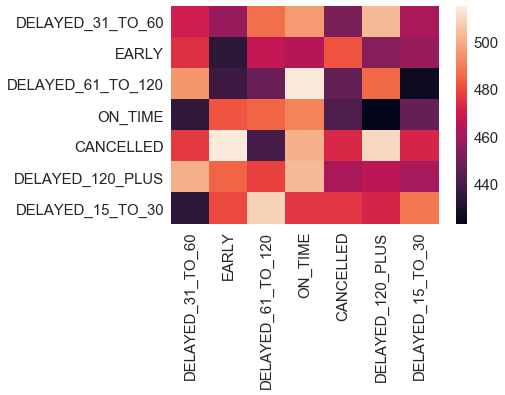

In [123]:
from sklearn.dummy import DummyClassifier

dummy_paramters = [
    {
        'select__k': ['all'],
        'classify': [DummyClassifier()],
        'classify__strategy': ['stratified'],
        'classify__random_state': [random_state]
    }
]

# Dummy Classifier provides a point of comparison for other classifiers, in this a rand
grid = evaluate_pipeline(features, target, dummy_paramters, pipeline, scoring='accuracy', random_state=random_state)

   Scoring Methodology: accuracy
            Best Score: 0.44245202558635394
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k='all', score_func=<function f_classif at 0x11d81ef28>)), ('approximate', None), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=3, p=2,
           weights='uniform'))])
----------------- Test Set Results -----------------
              Accuracy: 0.44753246753246756
 Classification Report:
                    precision    recall  f1-score   support

        CANCELLED       0.47      0.73      0.57      3388
 DELAYED_120_PLUS       0.37      0.43      0.40      3356
 DELAYED_15_TO_30       0.27      0.29      0.28      3336
 DELAYED_31_TO_60       0.25      0.18      0.20      3328
DELAYED_61_TO_120       0.27      0.17      0.20      3253
            EARLY       0.95      

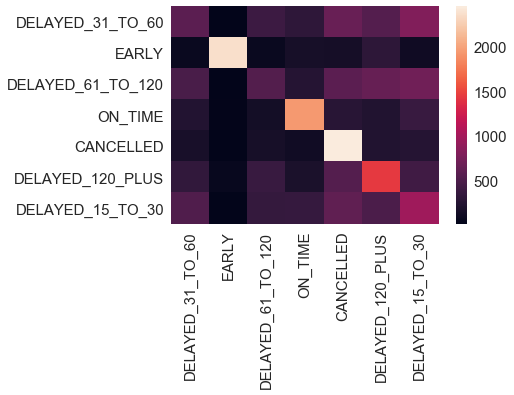

In [ ]:
from sklearn.neighbors import KNeighborsClassifier   

knn_parameters = [
    {
        'select__k': ['all'],
        'classify': [KNeighborsClassifier()],
        'classify__weights': ['uniform'],
        'classify__algorithm': ['auto'],
        'classify__n_neighbors': [3],
        'classify__n_jobs': [4],
    }
]

# Did not successfully run full dataset on local machine, due to resource limitations
grid = evaluate_pipeline(features, target, knn_parameters, pipeline, scoring='accuracy', random_state=random_state)

In [70]:
from sklearn.svm import SVC

svc_parameters = [
    {
        'select__k': [10, 'all'],
        'classify': [SVC()],
        'classify__class_weight': ['balanced'],
        'classify__kernel': ['rbf'],
        'classify__gamma': ['auto'],
        'classify__C': [1.0],
        'classify__random_state': [random_state]        
    }
]

# Stopped due to excessive runtime
#grid = evaluate_pipeline(X, y, svc_parameters, pipeline, scoring='precision', random_state=random_state)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_parameters = [
    {
        'select__k': [2,4,8,'all'],
        'classify': [RandomForestClassifier()],
        'classify__class_weight': ['balanced', 'balanced_subsample', None],
        'classify__criterion': ['gini', 'entropy'],
        'classify__max_features': ['auto', 'log2'],
        'classify__max_depth': [2, 10, 15, None],
        'classify__n_jobs': [4],
        'classify__random_state': [random_state]        
    }
]

grid = evaluate_pipeline(features, target, random_forest_parameters, pipeline, scoring='accuracy', random_state=random_state)

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

kernel_approximation_parameters = [
    {
        'approximate': [RBFSampler()],
        'approximate__gamma': [0.1, 1, 10],
        'approximate__n_components': [100],
        'classify': [SGDClassifier()],
        'classify__max_iter': [5],
        'classify__class_weight': ['balanced'],
        'classify__n_jobs': [4],
        'classify__random_state': [random_state]        
    }
]

grid = evaluate_pipeline(features, target, kernel_approximation_parameters, pipeline, scoring='accuracy', random_state=random_state)